### **LSTM for Time Series Forecast**

**Import ALL Library Package**

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

**Create Dataset, Splitting Data Training and Testing, Create the LSTM Model**

This are the steps:
1. Fetches historical stock data from Yahoo Finance.
2. Prepares and scales the data for use in an LSTM Model.
3. Trains the LSTM Model on past stock price data.
4. Predicts the stock price and evaluates accuracy with RMSE.
5. Plots and saves a comparison of actual vs. predicted prices.

In [ ]:
# Define stock tickers for the dropdown
tickers = ['BBCA.JK', 'BBRI.JK', 'BMRI.JK']

# Function to fetch stock data and make predictions
def stock_prediction(ticker, start_date, end_date):
    # Fetch historical stock data from Yahoo Finance
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    
    # Check if data is fetched
    if stock_data.empty:
        return "No data available for the given ticker and date range.", None
    
    # Prepare the data for LSTM Model
    df_close = stock_data[['Close', 'Open', 'High', 'Volume']]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df_close)
    
    # Split the Data into Train and Test sets (80:20)
    train_size = int(len(scaled_data) * 0.8)
    train_data, test_data = scaled_data[0:train_size], scaled_data[train_size:]
    
    # Create datasets for LSTM Model (Training and Testing)
    def create_dataset(data, time_step=1):
        x, y = [], []
        for i in range(len(data) - time_step - 1):
            x.append(data[i:(i + time_step), :])
            y.append(data[i + time_step, 0]) # Predicting 'Close' price
        return np.array(x), np.array(y)
    
    time_step = 1 # Using 1 previous days to predict the next
    train_x, train_y = create_dataset(train_data, time_step)
    test_x, test_y = create_dataset(test_data, time_step)
    
    # Reshape the data for LSTM [samples, time steps, features]
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2])
    test_x = test_x.reshape(test_x.shape[0], test_x.shape[1], test_x.shape[2])
    
    # Define LSTM Model with Validation Data
    lstm_model = tf.keras.Sequential([
        tf.keras.layers.LSTM(34, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])),
        tf.keras.layers.LSTM(64, return_sequences=False),
        tf.keras.layers.Dense(25),
        tf.keras.layers.Dense(1)
    ])
    
    # Compile the Model
    lstm_model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train the Model with Validation Data (10% of Training data for Validation)
    history = lstm_model.fit(train_x, train_y, epochs=50, batch_size=32, validation_split=0.1, verbose=1)
    
    # Predict on the Training data
    train_predictions = lstm_model.predict(train_x)
    train_predictions = scaler.inverse_transform(
        np.concatenate((train_predictions, np.zeros((train_predictions.shape[0], df_close.shape[1] - 1))), axis=1)
    )[:, 0]
    
    # Predict on the testing data
    test_predictions = lstm_model.predict(test_x)
    test_predictions = scaler.inverse_transform(
        np.concatenate((test_predictions, np.zeros((test_predictions.shape[0], df_close.shape[1] - 1))), axis=1)
    )[:, 0]
    
    # Calculate RMSE for both train and test sets
    actual_train_prices = df_close['Close'].values[:len(train_predictions)]
    actual_test_prices = df_close['Close'].values[train_size + time_step + 1:]
    train_rmse = np.sqrt(mean_squared_error(actual_train_prices, train_predictions))
    test_rmse = np.sqrt(mean_squared_error(actual_test_prices, test_predictions))
    
    # Create a plot to show only test predictions and actual stock prices
    plt.figure(figsize=(12, 6))

    # Plot the actual stock prices for the test data period
    plt.plot(range(train_size + time_step + 1, len(df_close['Close'].values)), actual_test_prices, label='Actual Stock Price', color='blue')

    # Plot the predicted test prices
    plt.plot(range(train_size + time_step + 1, len(df_close['Close'].values)), test_predictions, label='Test Predictions', color='orange')

    # Add title and labels
    plt.title(f'{ticker} Stock Price Test Data Prediction\nTest RMSE: {test_rmse:.4f}')
    plt.xlabel('Days')
    plt.ylabel('Stock Price')
    plt.legend()

    # Show the plot
    plt.show()

    return f"Prediction complete for {ticker}. Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}"

**Manually Input the Stocks and Date Range**

[*********************100%%**********************]  1 of 1 completed


Epoch 1/50
27/27 [==============================] - 4s 28ms/step - loss: 0.0852 - val_loss: 0.0222
Epoch 2/50
27/27 [==============================] - 0s 3ms/step - loss: 0.0162 - val_loss: 0.0427
Epoch 3/50
27/27 [==============================] - 0s 3ms/step - loss: 0.0093 - val_loss: 0.0202
Epoch 4/50
27/27 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0024
Epoch 5/50
27/27 [==============================] - 0s 4ms/step - loss: 7.7508e-04 - val_loss: 5.1845e-04
Epoch 6/50
27/27 [==============================] - 0s 3ms/step - loss: 4.5895e-04 - val_loss: 7.1750e-04
Epoch 7/50
27/27 [==============================] - 0s 4ms/step - loss: 4.5220e-04 - val_loss: 2.1873e-04
Epoch 8/50
27/27 [==============================] - 0s 4ms/step - loss: 4.3824e-04 - val_loss: 2.4203e-04
Epoch 9/50
27/27 [==============================] - 0s 4ms/step - loss: 4.4406e-04 - val_loss: 5.4585e-04
Epoch 10/50
27/27 [==============================] - 0s 4ms/step - loss: 4.40

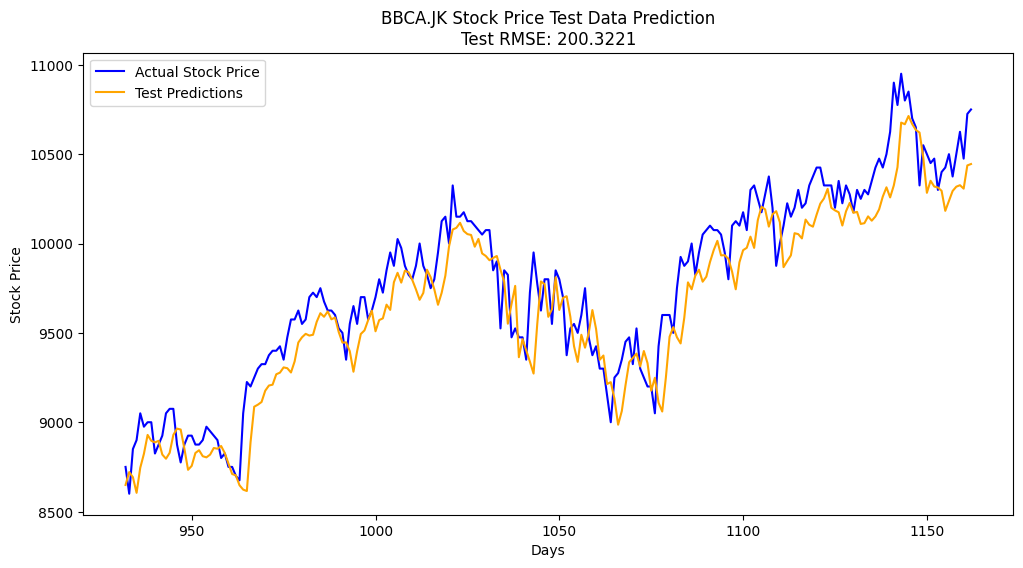

Prediction complete for BBCA.JK. Train RMSE: 66.6939, Test RMSE: 200.3221


In [12]:
# Manually input stock ticker and date range in Colab
ticker = input(f"Select Stock Ticker ({', '.join(tickers)}): ")
start_date = input("Enter Start Date (YYYY-MM-DD): ")
end_date = input("Enter End Date (YYYY-MM-DD): ")

# Call the prediction function
result_message = stock_prediction(ticker, start_date, end_date)
print(result_message)